In [1]:
import pybamm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math
import dfols
import signal
from scipy.integrate import solve_ivp
from scipy.fft import fft, fftfreq, fftshift
from scipy.signal import savgol_filter
from scipy.signal import find_peaks
from scipy import interpolate
from stopit import threading_timeoutable as timeoutable
import os, sys
sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath("__file__"))))
from batfuns import *
plt.rcParams = set_rc_params(plt.rcParams)

eSOH_DIR = "../data/esoh_R/"
oCV_DIR = "../data/ocv/"
fig_DIR = "../figures/figures_cal/"
res_DIR = "../data/results_cal/"

In [2]:
parameter_values = get_parameter_values()
spm = pybamm.lithium_ion.SPM(
    {
        "SEI": "ec reaction limited",
        # "loss of active material": ("stress-driven","none"),
        "loss of active material": "stress-driven",
        # "stress-induced diffusion": "true",
        # "lithium plating": "reversible",
    }
)
# spm.print_parameter_info()
param=spm.param

In [3]:
parameter_values.search("sei")

Initial inner SEI thickness [m]	2.5e-09
Initial outer SEI thickness [m]	2.5e-09
Inner SEI electron conductivity [S.m-1]	8.95e-14
Inner SEI lithium interstitial diffusivity [m2.s-1]	1e-20
Inner SEI open-circuit potential [V]	0.1
Inner SEI partial molar volume [m3.mol-1]	9.585e-05
Inner SEI reaction proportion	0.5
Outer SEI open-circuit potential [V]	0.8
Outer SEI partial molar volume [m3.mol-1]	9.585e-05
Outer SEI solvent diffusivity [m2.s-1]	2.5000000000000002e-22
Ratio of lithium moles to SEI moles	2.0
SEI growth activation energy [J.mol-1]	0.0
SEI kinetic rate constant [m.s-1]	1e-12
SEI open-circuit potential [V]	0.4
SEI reaction exchange current density [A.m-2]	1.5e-07
SEI resistivity [Ohm.m]	200000.0


In [4]:
cell = 22
sno = 1
# cell = 23

In [5]:
cell_no,dfe,N,dfo_0 = load_data_calendar(cell,eSOH_DIR,oCV_DIR)

In [6]:
# C_n_init,C_p_init,x_init,y_init,c_rate_c,c_rate_d,dis_set = init_exp(cell_no,dfe)
param = spm.param
eps_n_data,eps_p_data,SOC_0,Temp = init_exp_calendar(cell_no,dfe,param,parameter_values)

In [7]:
pybamm.set_logging_level("WARNING")
# pybamm.set_logging_level("NOTICE")
calendar_time = 24
experiment = pybamm.Experiment(
    [
        ("Rest for "+f'{calendar_time}'+" hours",)
    ]*int(N[-1]+10) ,
    termination="50% capacity",
#     cccv_handling="ode",
)

In [8]:
par_val = {}
# Previous i.e. tuning mech sim sep and then Li plating
par_val[0]=[1.2715e-07,1.2727e-06,1.1992,1.353e-9]
# Using only C/5 and 1.5C Cycling aging, cost function with Cn,Cp,x100,y0
par_val[1]=[1.4819e-07,1.5114e-06,1.2484,1.4732e-09]
# Using only C/5 and 1.5C Cycling aging, cost function with Cn,Cp,C,LLI(%)
par_val[2]=[1.4493e-07,1.3608e-06,1.199,1.2138e-09]
# Using C/5, 1.5C and mixed c-rate (Ch:C/5, Dh:1.5C) Cycling aging, cost function with Cn,Cp,x100,y0
par_val[3]=[1.043e-07,1.036e-06,1.208,1.6045e-09]
# Using C/5, 1.5C and mixed c-rate (Ch:C/5, Dh:1.5C) Cycling aging, cost function with Cn,Cp,C,LLI(%)
par_val[4]=[8.755e-08,8.572e-07,1.135,1.5788e-09]
# Using C/5, 1.5C and mixed c-rate (Ch:C/5, Dh:1.5C) Cycling aging, cost function with Cn,Cp,C,LLI(%) another initial condition
par_val[5]=[8.7698e-08,8.5848e-07,1.1354,1.5778e-09]

In [9]:
parameter_values.update(
    {
        "Negative electrode active material volume fraction": eps_n_data,
        "Positive electrode active material volume fraction": eps_p_data,
        "Initial temperature [K]": 273.15+Temp,
        "Ambient temperature [K]": 273.15+Temp,
        "Positive electrode LAM constant proportional term [s-1]": par_val[sno][0],
        "Negative electrode LAM constant proportional term [s-1]": par_val[sno][1],
        "Positive electrode LAM constant exponential term": par_val[sno][2],
        "Negative electrode LAM constant exponential term": par_val[sno][2],
        "SEI kinetic rate constant [m.s-1]":  4.60788219e-16, #1.08494281e-16 , 
        "EC diffusivity [m2.s-1]": 4.56607447e-19,#8.30909086e-19,
        "SEI growth activation energy [J.mol-1]": 1.87422275e+04,#1.58777981e+04,
        "Lithium plating kinetic rate constant [m.s-1]": par_val[sno][3],
        "Initial inner SEI thickness [m]": 0e-09,
        "Initial outer SEI thickness [m]": 5e-09,
        "SEI resistivity [Ohm.m]": 200000.0,
        # "SEI kinetic rate constant [m.s-1]": 1.6827e-16,
        # "EC diffusivity [m2.s-1]": 2e-18,
        # "SEI growth activation energy [J.mol-1]": 0,
    },
    check_already_exists=False,
)


In [10]:
# all_sumvars_dict = cycle_adaptive_simulation(spm, parameter_values, experiment,SOC_0, save_at_cycles=1)

In [11]:
parameter_values.update(
    {
        "SEI resistivity [Ohm.m]": 30000.0,
    },
    check_already_exists=False,
)
all_sumvars_dict1 = cycle_adaptive_simulation(spm, parameter_values, experiment,SOC_0, save_at_cycles=1)

In [12]:
# fig = plotc2(all_sumvars_dict,all_sumvars_dict1,dfe);
# plt.savefig(fig_DIR +'calendar_aging_cell_'+cell_no+'_eSOH.png')

In [13]:
# ssss

In [29]:
experiment_pulse = pybamm.Experiment(
    [
        "Rest for 10 sec",
        "Discharge at "+'1C'+" for 10 sec",
        "Rest for 60 sec",
        # "Charge at "+'C/20'+" until 4.2V", 
        # "Hold at 4.2V until C/50"
    ],
)

In [31]:
t_in0 = 10
t_in1 = 10
t_inf = t_in0+t_in1
# t_in = np.arange(0,t_inf,0.1)
t_in = np.arange(0,t_inf,1)
# t_sim = np.arange(0,t_inf,0.01)
I_in = []
for tt in t_in:
    if tt<t_in0:
        I_in = np.append(I_in,0)
    elif tt>=t_in0 and tt<t_in0+t_in1:
        I_in = np.append(I_in,5)
# I_in = np.array([0,0,5,5,0,0,-5,-5,0,0])
timescale = parameter_values.evaluate(spm.timescale)

In [32]:
def get_pulse_res(parameter_values,SOC):
    sim_pulse = pybamm.Simulation(spm, parameter_values=parameter_values, 
                            solver=pybamm.CasadiSolver(mode="safe", rtol=1e-6, atol=1e-6,dt_max=0.1))
    sol_pulse = sim_pulse.solve(t_eval=t_in,initial_soc = SOC)
    I   =  sol_pulse["Current [A]"].entries
    Vt  =  sol_pulse["Terminal voltage [V]"].entries
    idx = np.where(np.diff(np.sign(-I)))[0]
    Rs = abs((Vt[idx+1]-Vt[idx])/(I[idx+1]-I[idx]))[0]
    t  =  sol_pulse["Time [s]"].entries
    fig, axes = plt.subplots(2,1)
    ax1 = axes.flat[0]
    ax1.plot(t,I)
    ax1.plot(t[idx],I[idx],"^")
    ax1.plot(t[idx+1],I[idx+1],"v")
    ax1.set_title('Current')
    ax2 = axes.flat[1]
    ax2.plot(t,Vt)
    ax2.plot(t[idx],Vt[idx],"^")
    ax2.plot(t[idx+1],Vt[idx+1],"v")
    ax2.set_title('Voltage')
    ax2.set_xlabel('Time [s]')
    fig.tight_layout()
    return Rs

In [17]:
Ns = [int(i) for i in N]

In [35]:
def get_Rs(cyc_no,eSOH,parameter_values):
  Cn = eSOH["C_n"][Ns[cyc_no]]
      # print(Cn)
  Cp = eSOH["C_p"][Ns[cyc_no]]
  c_n_max = parameter_values.evaluate(param.n.prim.c_max)
  c_p_max = parameter_values.evaluate(param.p.prim.c_max)
  n_Li_init = eSOH["Total lithium in particles [mol]"][Ns[cyc_no]]
  eps_n_data = parameter_values.evaluate(Cn*3600/(param.n.L * param.n.prim.c_max * param.F* param.A_cc))
  eps_p_data = parameter_values.evaluate(Cp*3600/(param.p.L * param.p.prim.c_max * param.F* param.A_cc))
  del_sei = eSOH['X-averaged SEI thickness [m]'][Ns[cyc_no]]
  parameter_values.update(
          {
              "Negative electrode active material volume fraction": eps_n_data,
              "Positive electrode active material volume fraction": eps_p_data,
              "Initial temperature [K]": 273.15,
              "Ambient temperature [K]": 273.15,
              "Initial inner SEI thickness [m]": 0e-09,
              "Initial outer SEI thickness [m]": del_sei,
              
          }
        )
  timescale = parameter_values.evaluate(spm.timescale)
  current_interpolant = pybamm.Interpolant(
    t_in, -I_in, timescale * pybamm.t
  )
  parameter_values["Current function [A]"] = current_interpolant
  SOC_vals = np.linspace(1,0,11)
  Rs_ch_s = []
  # for SOC in SOC_vals[1:10]:
  for SOC in SOC_vals[2:3]:
      Rs_t = get_pulse_res(parameter_values,SOC)
      Rs_ch_s.append(Rs_t)
  Rs_ch = np.average(Rs_ch_s)
  
  current_interpolant = pybamm.Interpolant(
    t_in, I_in, timescale * pybamm.t
  )
  parameter_values["Current function [A]"] = current_interpolant
  SOC_vals = np.linspace(1,0,11)
  Rs_dh_s = []
  # for SOC in SOC_vals[1:10]:
  for SOC in SOC_vals[2:3]:
      Rs_t = get_pulse_res(parameter_values,SOC)
      Rs_dh_s.append(Rs_t)
  Rs_dh = np.average(Rs_dh_s)
  Rs = (Rs_dh + Rs_ch)/2
  return Rs

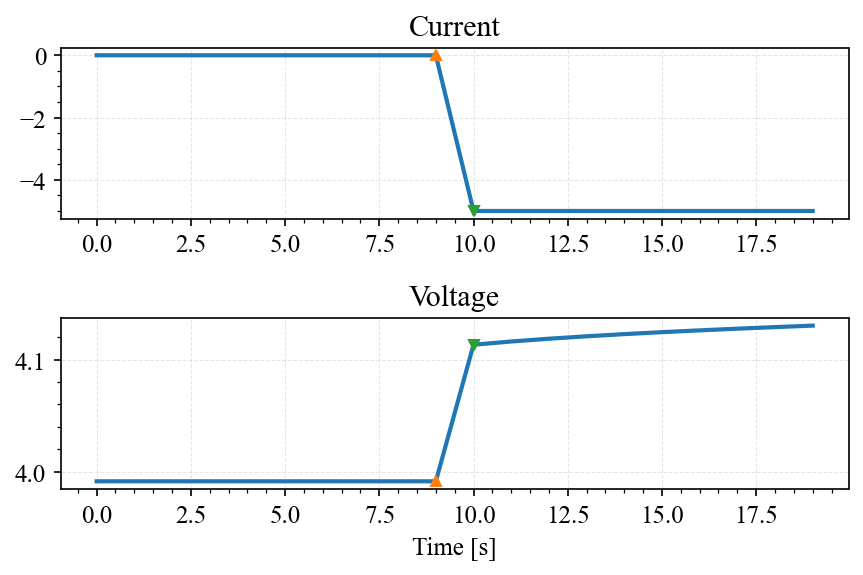

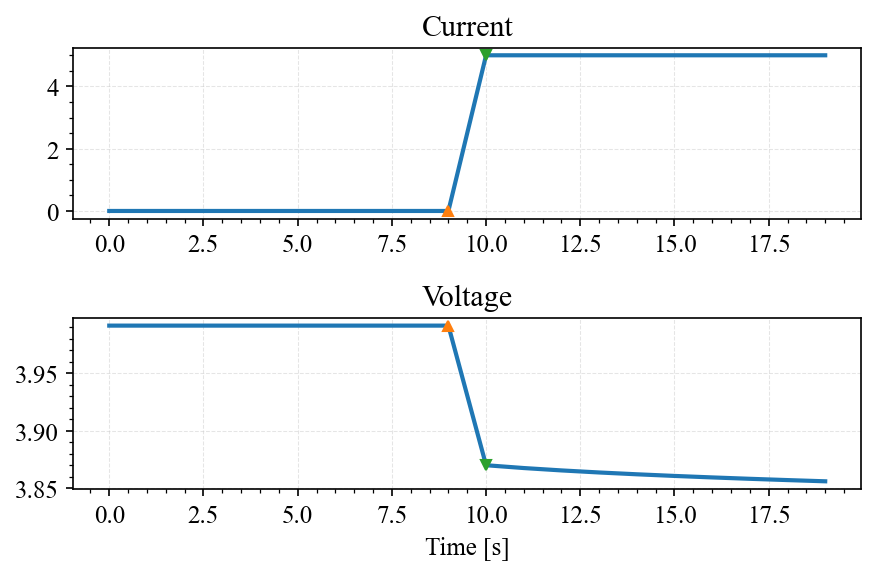

In [36]:
i = 0
Rs = []
# for cyc_no in [0,int((len(N)+1)/2),len(N)-2]:
# for cyc_no in [0,len(N)-2]:
# for cyc_no in range(len(Ns)):
for cyc_no in [0]:
    parameter_values.update(
    {
        "Positive electrode LAM constant proportional term [s-1]": par_val[1][0],
        "Negative electrode LAM constant proportional term [s-1]": par_val[1][1],
        "Positive electrode LAM constant exponential term": par_val[1][2],
        "Negative electrode LAM constant exponential term": par_val[1][2],
        "Lithium plating kinetic rate constant [m.s-1]": par_val[1][3],
    },
    check_already_exists=False,
    )
    Rs_t = get_Rs(cyc_no,all_sumvars_dict1,parameter_values)
    Rs.append(Rs_t)
    

In [ ]:
fig, ax = plt.subplots(1,1)
ax.plot(dfe["Time"],dfe["Rs_ave"],'kx-')
ax.plot(Ns,Rs,'rx-')
ax.set_xlabel('Time [days]')
ax.set_ylabel(r'DCR Average [$\Omega$]')
ax.legend(['Data','Sim'])
ax.set_title("Calendar Aging 100% SOC Hot Resistance")
plt.savefig(fig_DIR +'calendar_aging_cell_'+cell_no+'_resistance.png')

In [ ]:
30000/200000

In [ ]:
dsdfs

In [ ]:
sim_long = pybamm.Simulation(spm, experiment=experiment, parameter_values=parameter_values, 
                            solver=pybamm.CasadiSolver("safe"))
sol_long = sim_long.solve(initial_soc=1)
long_sol_output =sol_long.summary_variables

In [ ]:
first_states = sol_long.all_first_states